# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [4]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: y_random ответ для predict_proba, этот метод возвращает вероятности положительного класса для каждого объекта

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [3]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

AUC-PR: 0.50567
AUC-ROC: 0.50000


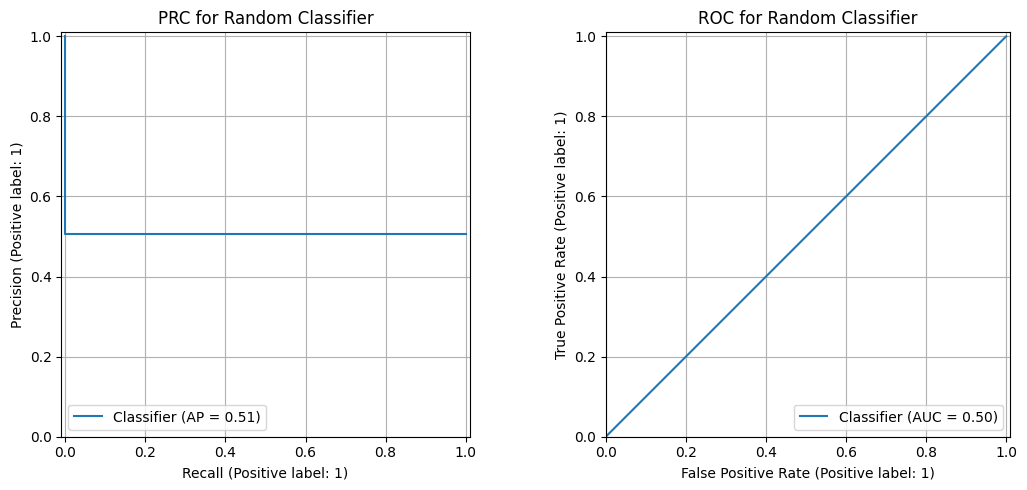

In [6]:
def plot_roc_pr_curves(y_test, y_pred, method_name='Random Classifier'):
    _, ax = plt.subplots(1, 2, figsize=(11, 5))
    PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax[0])
    print(f'AUC-PR: {average_precision_score(y_test, y_pred):.5f}')
    ax[0].set_title(f"PRC for {method_name}")
    ax[0].set_ylim(0, 1.01)
    ax[0].grid()

    RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax[1])
    print(f'AUC-ROC: {roc_auc_score(y_test, y_pred):.5f}')
    ax[1].set_title(f"ROC for {method_name}")
    ax[1].set_ylim(0, 1.01)
    ax[1].set_xlim(0, 1.01)
    ax[1].grid()

    plt.tight_layout()


plot_roc_pr_curves(y_test, y_random, 'Random Classifier')

In [7]:
# dataframe для сравнения 
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])

# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    average_precision_score(y_test, y_random),
    roc_auc_score(y_test, y_random),
    0
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

params_grid = {'C': np.logspace(-5, 1, 10)}
auc_pr_scorer = make_scorer(average_precision_score, greater_is_better=True)

model_svm = SVC(kernel='linear', probability=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=model_svm, param_grid=params_grid, 
                           scoring=auc_pr_scorer, cv=cv, verbose=2
                           )

_ = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ............................................C=1e-05; total time=   1.8s
[CV] END ............................................C=1e-05; total time=   2.0s
[CV] END ............................................C=1e-05; total time=   2.1s
[CV] END ............................................C=1e-05; total time=   1.8s
[CV] END ............................................C=1e-05; total time=   1.9s
[CV] END ............................C=4.641588833612782e-05; total time=   1.5s
[CV] END ............................C=4.641588833612782e-05; total time=   1.5s
[CV] END ............................C=4.641588833612782e-05; total time=   1.5s
[CV] END ............................C=4.641588833612782e-05; total time=   1.4s
[CV] END ............................C=4.641588833612782e-05; total time=   1.5s
[CV] END ...........................C=0.00021544346900318823; total time=   1.2s
[CV] END ...........................C=0.00021544

In [9]:
best_C = grid_search.best_params_['C']
print(f"Лучший параметр C: {best_C}")

best_model_svm = grid_search.best_estimator_
y_pred_proba_svm = best_model_svm.predict_proba(X_test)[:, 1]

Лучший параметр C: 0.021544346900318822


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

AUC-PR: 0.81538
AUC-ROC: 0.84790


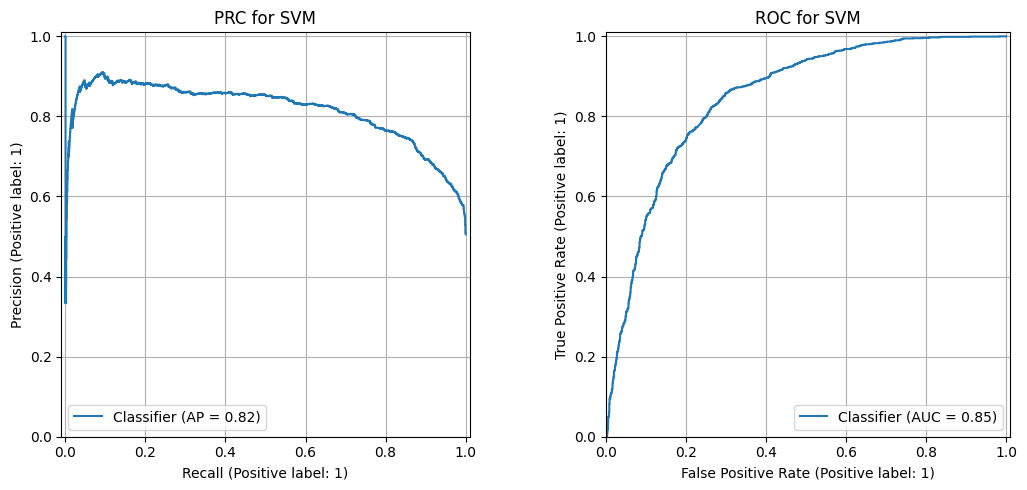

In [10]:
plot_roc_pr_curves(y_test, y_pred_proba_svm, 'SVM')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [11]:
df_metrics.loc['SVM'] = [
    average_precision_score(y_test, y_pred_proba_svm),
    roc_auc_score(y_test, y_pred_proba_svm),
    best_C
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.505667,0.5000,0.000000
SVM,0.815379,0.8479,0.021544


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

auc_pr_scorer = make_scorer(average_precision_score, greater_is_better=True)


model_log_reg = Pipeline([('log_reg', LogisticRegression(penalty='l2'))])

params_grid = {'log_reg__C': np.logspace(-5, 3, 20)}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=model_log_reg, param_grid=params_grid, 
                           scoring=auc_pr_scorer, cv=cv, verbose=1
                           )

_ = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [13]:
best_C = grid_search.best_params_['log_reg__C']
print(f"Лучший параметр C: {best_C}")

best_model_log_reg = grid_search.best_estimator_
y_pred_proba_lreg = best_model_log_reg.predict_proba(X_test)[:, 1]

Лучший параметр C: 0.023357214690901212


AUC-PR: 0.82970
AUC-ROC: 0.84775


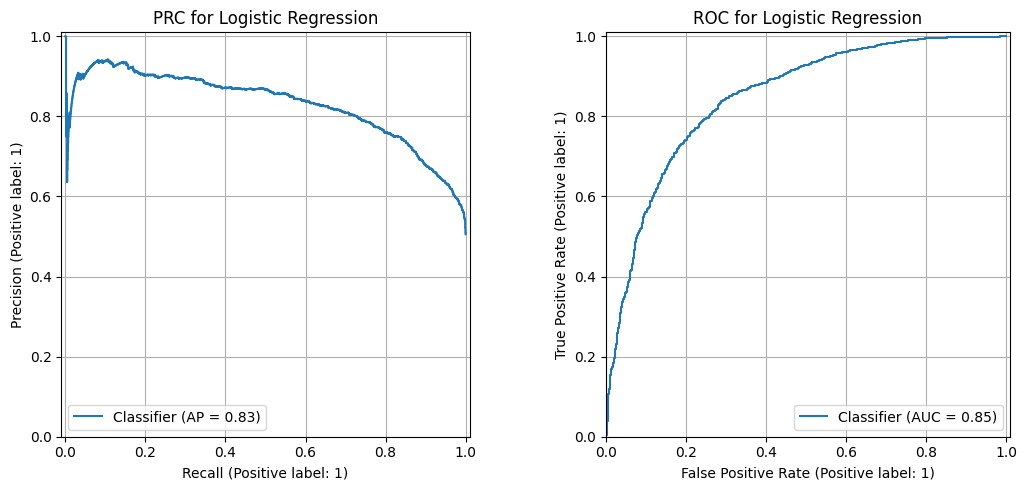

In [14]:
plot_roc_pr_curves(y_test, y_pred_proba_lreg, 'Logistic Regression')

In [15]:
df_metrics.loc['log_reg'] = [
    average_precision_score(y_test, y_pred_proba_lreg),
    roc_auc_score(y_test, y_pred_proba_lreg),
    best_C
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.505667,0.500000,0.000000
SVM,0.815379,0.847900,0.021544
log_reg,0.829701,0.847749,0.023357


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

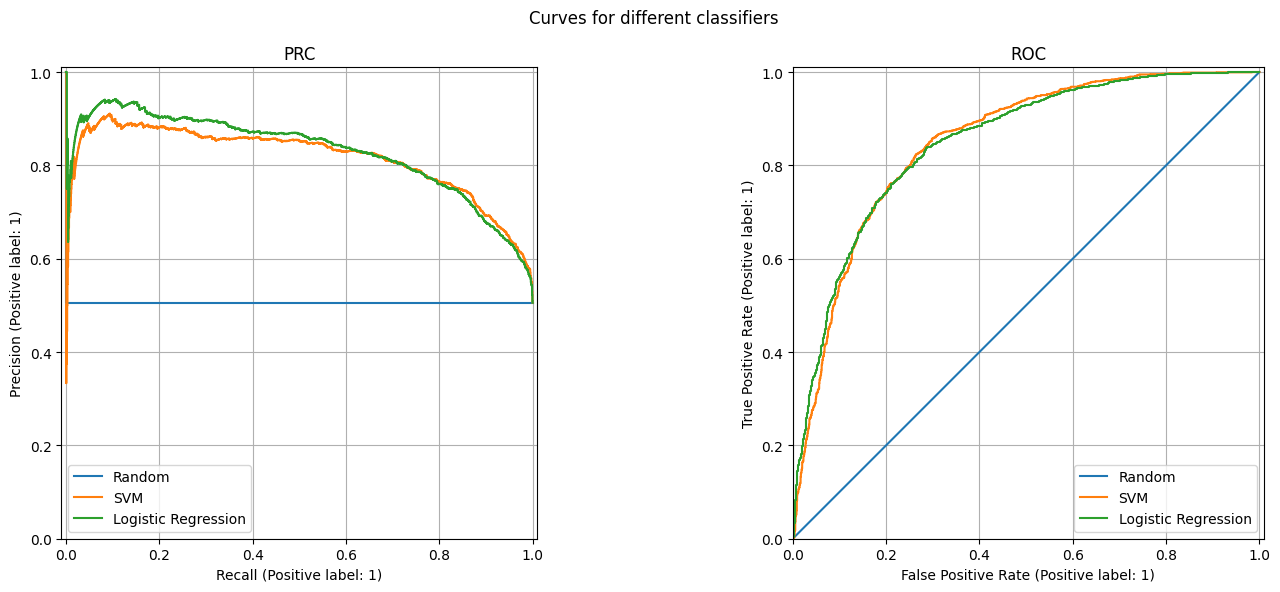

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0], label='Random')
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba_svm, ax=ax[0], label='SVM')
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba_lreg, ax=ax[0], label='Logistic Regression')
ax[0].set_title(f"PRC")
ax[0].set_ylim(0, 1.01)
ax[0].grid()

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1], label='Random')
RocCurveDisplay.from_predictions(y_test, y_pred_proba_svm, ax=ax[1], label='SVM')
RocCurveDisplay.from_predictions(y_test, y_pred_proba_lreg, ax=ax[1], label='Logistic Regression')
ax[1].set_title(f"ROC")
ax[1].set_ylim(0, 1.01)
ax[1].set_xlim(0, 1.01)
ax[1].grid()

fig.suptitle('Curves for different classifiers')

plt.tight_layout()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Данные подходы практически идентичны из-за того, что в SVC уже содержится калибровка вероятностей

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [17]:
X, y = make_classification(
    n_samples=400,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    random_state=42
)

model_svm = Pipeline([
    ('svm', SVC(kernel='linear', probability=True))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params_grid = {'svm__C': np.logspace(-5, 2, 20)}

grid_search = GridSearchCV(estimator=model_svm, param_grid=params_grid, 
                            scoring=auc_pr_scorer, cv=cv    
                           )

_ = grid_search.fit(X, y)

In [18]:
best_model_svm = grid_search.best_estimator_

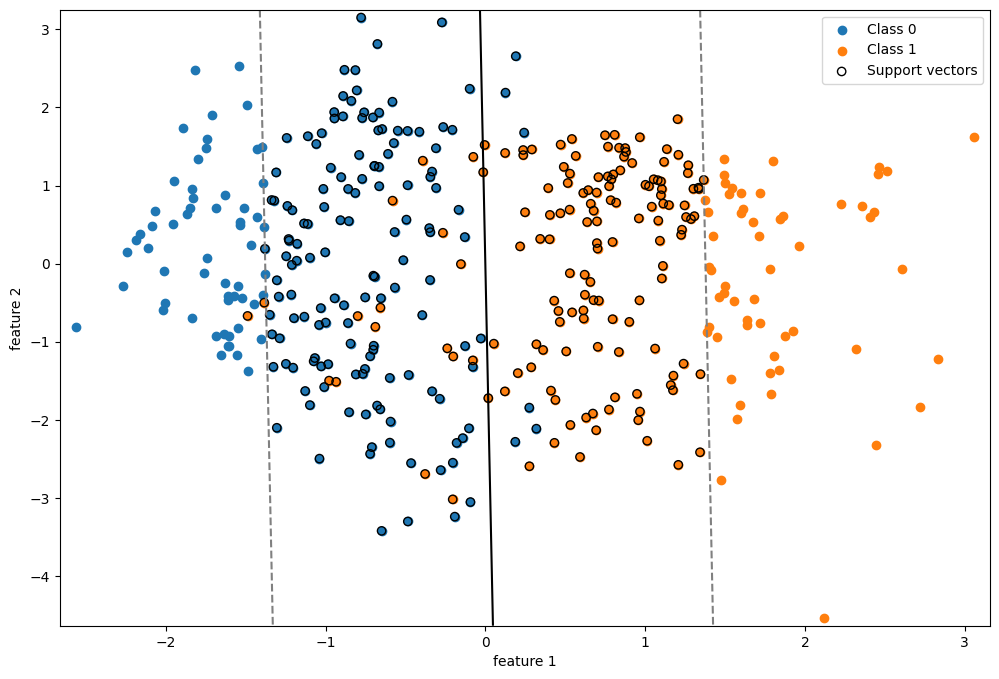

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))

class_0 = X[y == 0]
class_1 = X[y == 1]

support_vectors = best_model_svm.named_steps['svm'].support_vectors_

ax.scatter(class_0[:, 0], class_0[:, 1], label='Class 0')
ax.scatter(class_1[:, 0], class_1[:, 1], label='Class 1')
ax.scatter(support_vectors[:, 0], support_vectors[:, 1], label='Support vectors', edgecolor='black', facecolor='none')

w = best_model_svm.named_steps['svm'].coef_[0]
b = best_model_svm.named_steps['svm'].intercept_
x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx1 = np.linspace(x1_min, x1_max, 100)
xx2 = np.linspace(x2_min, x2_max, 100)
XX1, XX2 = np.meshgrid(xx1, xx2)

Z = w[0] * XX1 + w[1] * XX2 + b

ax.contour(XX1, XX2, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors=['grey', 'black', 'grey'])

ax.legend()
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
plt.show()

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Объект является опорным, если он лежит на границе разделяющей полосы или не с той стороны, с которой его класс

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [20]:
X, y = make_classification(
    n_samples=450,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    random_state=42
)

model_log_reg = Pipeline([
    ('log_reg', LogisticRegression(penalty='l2'))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params_grid = {'log_reg__C': np.logspace(-5, 2, 20)}

grid_search = GridSearchCV(estimator=model_log_reg, param_grid=params_grid, 
                            scoring=auc_pr_scorer, cv=cv    
                           )

_ = grid_search.fit(X, y)

In [21]:
best_model_log_reg = grid_search.best_estimator_

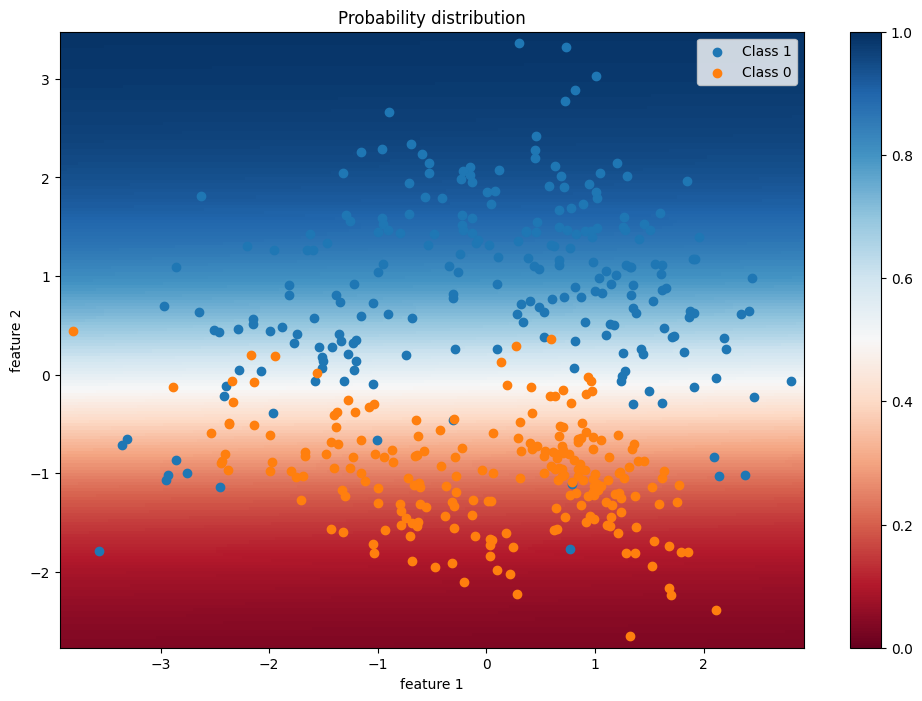

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))

x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx1 = np.linspace(x1_min, x1_max, 200)
xx2 = np.linspace(x2_min, x2_max, 200)
XX1, XX2 = np.meshgrid(xx1, xx2)

grid_points = np.c_[XX1.ravel(), XX2.ravel()]

z = best_model_log_reg.predict_proba(grid_points)[:, 1]
c = ax.pcolor(XX1, XX2, z.reshape(XX1.shape), cmap='RdBu', vmin=0, vmax=1)
ax.set_title('Probability distribution')
fig.colorbar(c, ax=ax)

class_0 = X[y == 0]
class_1 = X[y == 1]

ax.scatter(class_1[:, 0], class_1[:, 1], label='Class 1')
ax.scatter(class_0[:, 0], class_0[:, 1], label='Class 0')
ax.legend()
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
plt.show()

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** На картинке область максимальной неуверенности модели выделена белым цветом. Здесь модель предсказывает класс случайно

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [23]:
def plot_calibration_curve(y_test, preds, model_name='SVM'):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 15
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    _, ax = plt.subplots(figsize=(8, 8))
    ax.plot(bin_middle_points, bin_real_ratios, label=f'{model_name} calibration curve')
    ax.scatter(bin_middle_points, bin_real_ratios)
    ax.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), label=f'Perfect calibration curve')
    ax.set_ylim([-0.05, 1.05])
    ax.grid()
    ax.legend()
    plt.show()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [24]:
from sklearn.svm import LinearSVC
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

С_grid = np.logspace(-4, 1, 10)
best_score = np.inf
C_best = None

for C in С_grid:
    model_svm = LinearSVC(C=C)
    _ = model_svm.fit(X_train, y_train)
    y_logits = model_svm.decision_function(X_test)
    y_proba = (y_logits - y_logits.min()) / (y_logits.max() - y_logits.min())
    score = average_precision_score(y_test, y_proba)
    if score < best_score:
        best_score = score
        C_best = C

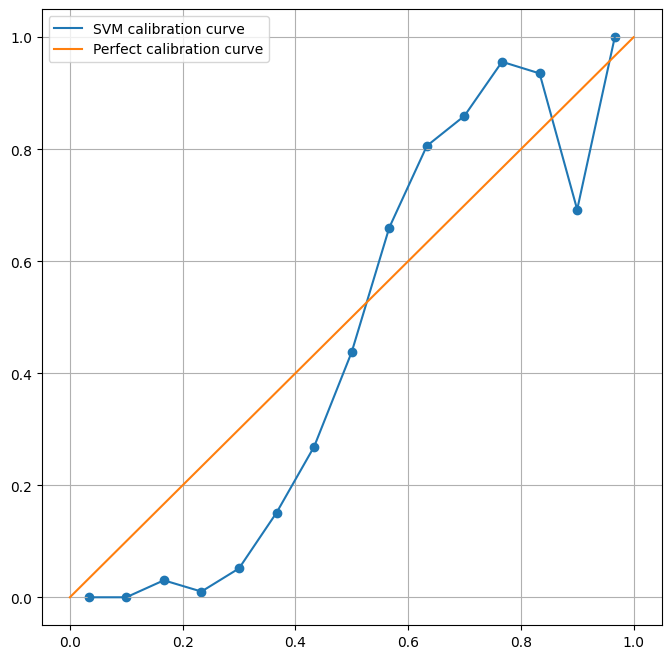

In [25]:
best_model = LinearSVC(C=C_best)
_ = best_model.fit(X_train, y_train)
y_logits = best_model.decision_function(X_test)
y_proba = (y_logits - y_logits.min()) / (y_logits.max() - y_logits.min())
plot_calibration_curve(y_test, y_proba, model_name='SVM')

In [26]:
model_log_reg = Pipeline([
    ('log_reg', LogisticRegression(penalty='l2'))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params_grid = {'log_reg__C': np.logspace(-5, 2, 20)}

grid_search = GridSearchCV(estimator=model_log_reg, param_grid=params_grid, 
                            scoring=auc_pr_scorer, cv=cv    
                           )

_ = grid_search.fit(X, y)

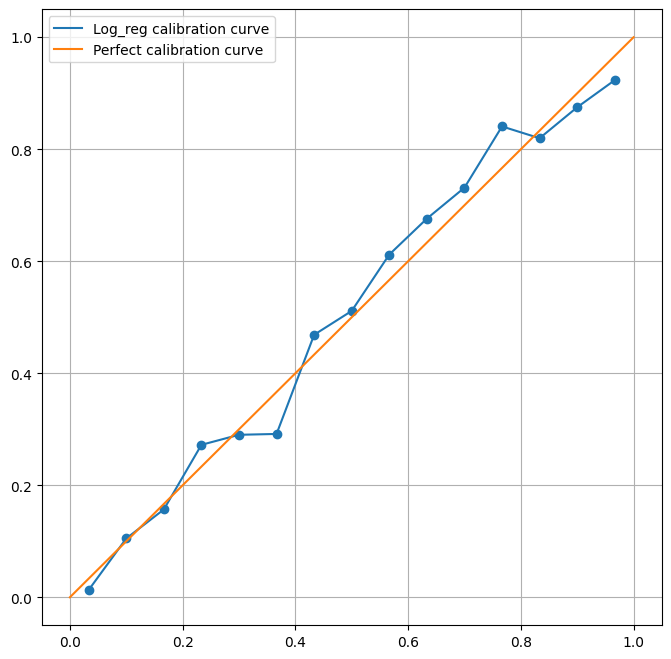

In [27]:
best_model_log_reg = grid_search.best_estimator_
y_pred_log_reg = best_model_log_reg.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, y_pred_log_reg, model_name='Log_reg')

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** Стандартный SVM с min_max калибровкой работает не очень хорошо

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

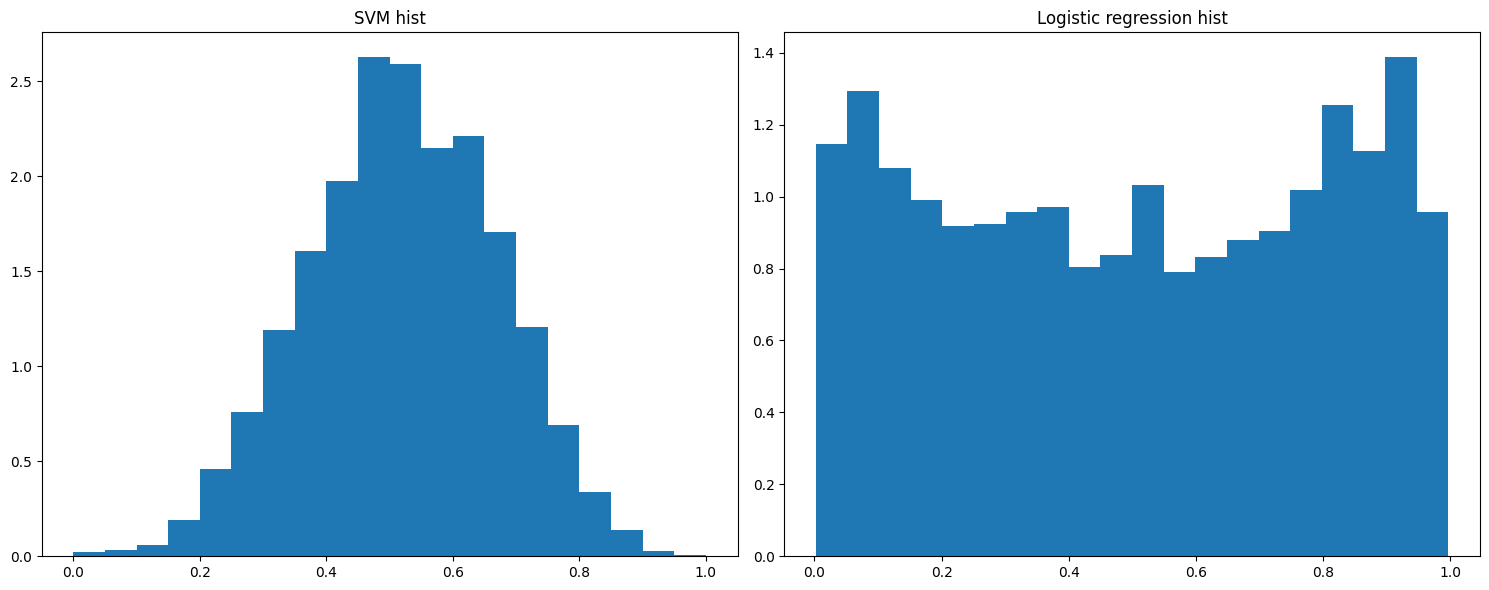

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
ax[0].hist(y_proba, bins=20, density='True')
ax[1].hist(y_pred_log_reg, bins=20, density='True')

ax[0].set_title('SVM hist')
ax[1].set_title('Logistic regression hist')
plt.tight_layout()
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** У SVM пик предскзаний находится по-середине, что говорит о том, что чаще всего он не уверен в своих предсказаниях. Логистическая регрессия имеет более правильное распределение с двумя пиками по краям

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

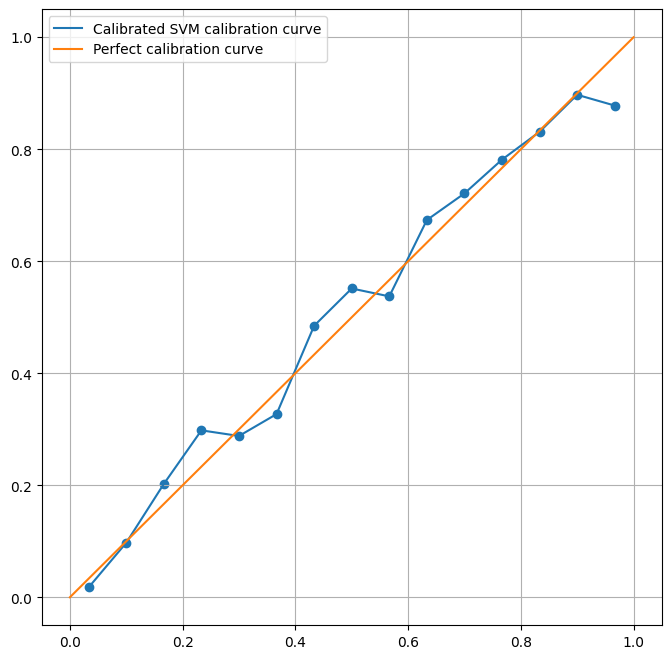

In [29]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_svm = CalibratedClassifierCV(best_model, cv=3, method='isotonic')

_ = calibrated_svm.fit(X_train, y_train)

y_pred_calibrated_svm = calibrated_svm.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, y_pred_calibrated_svm, model_name='Calibrated SVM')

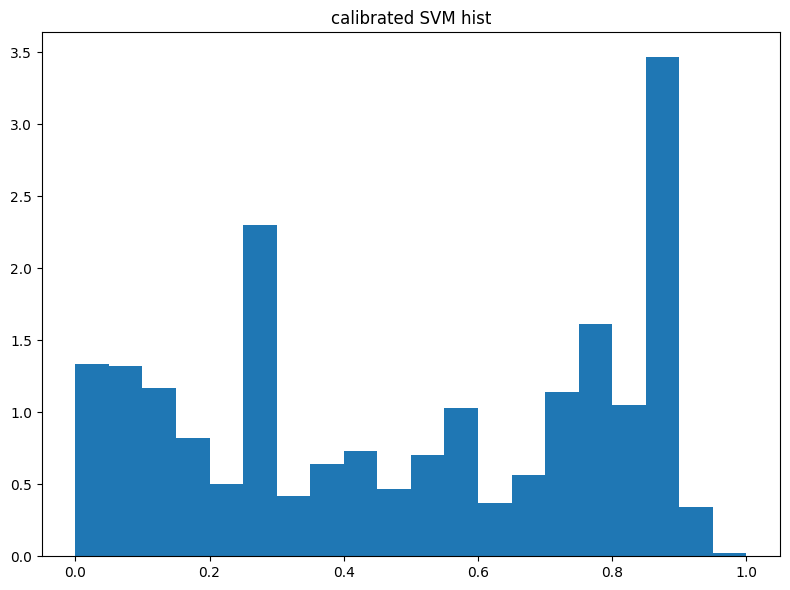

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(y_pred_calibrated_svm, bins=20, density='True')

ax.set_title('calibrated SVM hist')
plt.tight_layout()
plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Калибровочная кривая заметно улучшилась

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [9]:
df = pd.read_csv('bike_buyers.csv')
df.head(5)

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


In [8]:
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 
                 'Home Owner', 'Commute Distance', 'Region']
numerical = ['Income', 'Children', 'Cars', 'Age']

In [10]:
df = pd.read_csv('bike_buyers.csv')
#Заменим пропуски категориальных переменных
df[categorical] = df[categorical].fillna('undefined')

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X_numerical = X[numerical]
X_categorical = X[categorical]

В начале поработаем только с категориальными признаками

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [36]:
import time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('orde', OrdinalEncoder(handle_unknown='error'), categorical)
])

pipeline = Pipeline([
    ('col_tranformer', column_transformer),
    ('model', LogisticRegression(random_state=42))
])

start_time = time.time()

model = pipeline.fit(X_train, y_train)

end_time = time.time()

training_time = end_time - start_time

print(f'Время обучения модели с учётом кодирования признаков: {training_time:.4f} секунд')

y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_prс = average_precision_score(y_test, y_pred_proba)
print(f'AUC-PRC: {auc_prс:.5f}')

Время обучения модели с учётом кодирования признаков: 0.0064 секунд
AUC-PRC: 0.58865


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [79]:
from sklearn.preprocessing import OneHotEncoder

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)
])

pipeline = Pipeline([
    ('col_tranformer', column_transformer),
    ('model', LogisticRegression(random_state=42))
])

start_time = time.time()

model = pipeline.fit(X_train, y_train)

end_time = time.time()

training_time = end_time - start_time

print(f'Время обучения модели с учётом кодирования признаков: {training_time:.4f} секунд')

y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_prс = average_precision_score(y_test, y_pred_proba)
print(f'AUC-PRC: {auc_prс:.5f}')

Время обучения модели с учётом кодирования признаков: 0.0325 секунд
AUC-PRC: 0.66625


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class mean_target_Encoder(BaseEstimator, TransformerMixin):

    def __init__(self, encode_columns, target_column):
        self.encode_columns = encode_columns
        self.target_column = target_column
        self.counters = dict()
    
    def fit(self, X, y):
        X = X[self.encode_columns].copy()
        y = y.copy()
        data = pd.concat([X, y], axis=1)
        for col in self.encode_columns:
            self.counters[col] = data.groupby(col)[self.target_column].mean()
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for col in self.encode_columns:
            X[col] = X[col].map(self.counters[col])
        return X

In [80]:
column_transformer = ColumnTransformer([
    ('mte', mean_target_Encoder(categorical, 'Purchased Bike'), categorical)
])

pipeline = Pipeline([
    ('col_tranformer', column_transformer),
    ('model', LogisticRegression(random_state=42))
])

start_time = time.time()

model = pipeline.fit(X_train, y_train)

end_time = time.time()

training_time = end_time - start_time

print(f'Время обучения модели с учётом кодирования признаков: {training_time:.4f} секунд')

y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_prс = average_precision_score(y_test, y_pred_proba)
print(f'AUC-PRC: {auc_prс:.5f}')

Время обучения модели с учётом кодирования признаков: 0.0260 секунд
AUC-PRC: 0.65751


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [94]:
class noisy_mean_target_Encoder(BaseEstimator, TransformerMixin):

    def __init__(self, encode_columns, target_column, noise):
        self.encode_columns = encode_columns
        self.target_column = target_column
        self.counters = dict()
        self.noise = noise
    
    def fit(self, X, y):
        X = X[self.encode_columns].copy()
        y = y.copy()
        data = pd.concat([X, y], axis=1)
        for col in self.encode_columns:
            self.counters[col] = data.groupby(col)[self.target_column].mean()
            self.counters[col] += np.random.randn(len(self.counters[col])) * self.noise
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for col in self.encode_columns:
            X[col] = X[col].map(self.counters[col])
        return X

In [97]:
column_transformer = ColumnTransformer([
    ('nmte', noisy_mean_target_Encoder(categorical, 'Purchased Bike', noise=0), categorical)
])

model = Pipeline([
    ('col_tranformer', column_transformer),
    ('model', LogisticRegression(random_state=42))
])

auc_pr_scorer = make_scorer(average_precision_score, greater_is_better=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params_grid = {'col_tranformer__nmte__noise': np.logspace(-5, 2, 20)}

grid_search = GridSearchCV(estimator=model, param_grid=params_grid, 
                            scoring=auc_pr_scorer, cv=cv    
                           )

_ = grid_search.fit(X_train, y_train)

In [99]:
print(f'Лучший шум: {grid_search.best_params_['col_tranformer__nmte__noise']}')
best_model = grid_search.best_estimator_

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc_prс = average_precision_score(y_test, y_pred_proba)
print(f'AUC-PRC: {auc_prс:.5f}')

Лучший шум: 0.008858667904100823
AUC-PRC: 0.66084


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Добавление шума действительно немного улучшило предскзания модели на тестовой выборке, потому что снизилось переобучение

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [29]:
class smooth_mean_target_Encoder(BaseEstimator, TransformerMixin):

    def __init__(self, encode_columns, target_column, C):
        self.encode_columns = encode_columns
        self.target_column = target_column
        self.counters = dict()
        self.C = C
        self.global_mean = None
    
    def fit(self, X, y):
        X = X[self.encode_columns].copy()
        y = y.copy()
        data = pd.concat([X, y], axis=1)
        self.global_mean = y.mean()
        for col in self.encode_columns:
            num = data.groupby(col)[self.target_column].sum()
            den = data[col].value_counts()
            self.counters[col] = (num + self.C * self.global_mean) / (den + self.C)

            self.counters[col] = self.counters[col].replace([np.inf, -np.inf], self.global_mean)
            self.counters[col] = self.counters[col].fillna(self.global_mean)
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for col in self.encode_columns:
            X[col] = X[col].map(self.counters[col])

            X[col] = X[col].replace([np.inf, -np.inf], self.global_mean)
            X[col] = X[col].fillna(self.global_mean)
        return X

In [251]:
column_transformer = ColumnTransformer([
    ('smte', smooth_mean_target_Encoder(categorical, 'Purchased Bike', C=0), categorical)
])

model = Pipeline([
    ('col_tranformer', column_transformer),
    ('model', LogisticRegression(random_state=42))
])

auc_pr_scorer = make_scorer(average_precision_score, greater_is_better=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params_grid = {'col_tranformer__smte__C': np.linspace(-100, 100, 40)}

grid_search = GridSearchCV(estimator=model, param_grid=params_grid, 
                            scoring=auc_pr_scorer, cv=cv    
                           )

_ = grid_search.fit(X_train, y_train)

In [252]:
print(f'Лучшее сглаживание: {grid_search.best_params_['col_tranformer__smte__C']}')
best_model = grid_search.best_estimator_

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc_prс = average_precision_score(y_test, y_pred_proba)
print(f'AUC-PRC: {auc_prс:.5f}')

Лучшее сглаживание: -38.46153846153845
AUC-PRC: 0.68142


Получили качество лучше, чем при использовании One-Hot кодирования

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [11]:
X_numerical = X_numerical.fillna(X_numerical.mean())

In [12]:
X = pd.concat([X_numerical, X_categorical], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [263]:
column_transformer = ColumnTransformer([
    ('smte', smooth_mean_target_Encoder(categorical, 'Purchased Bike', C=0), categorical)
])

model = Pipeline([
    ('col_tranformer', column_transformer),
    ('model', LogisticRegression(random_state=42))
])

auc_pr_scorer = make_scorer(average_precision_score, greater_is_better=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params_grid = {'col_tranformer__smte__C': np.linspace(-100, 100, 40)}

grid_search = GridSearchCV(estimator=model, param_grid=params_grid, 
                            scoring=auc_pr_scorer, cv=cv    
                           )

_ = grid_search.fit(X_train, y_train)

In [264]:
print(f'Лучшее сглаживание: {grid_search.best_params_['col_tranformer__smte__C']}')
best_model = grid_search.best_estimator_

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc_prс = average_precision_score(y_test, y_pred_proba)
print(f'AUC-PRC: {auc_prс:.5f}')

Лучшее сглаживание: -38.46153846153845
AUC-PRC: 0.68142


 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [265]:
X_numerical.nunique()

Income      17
Children     7
Cars         6
Age         54
dtype: int64

In [ ]:
from itertools import combinations

for r in range(len(numerical) + 1):

    for num_cols in combinations(numerical, r):
        new_categorical = categorical + list(num_cols)

        column_transformer = ColumnTransformer([
            ('smte', smooth_mean_target_Encoder(new_categorical, 'Purchased Bike', C=0), new_categorical)
        ])

        model = Pipeline([
            ('col_tranformer', column_transformer),
            ('model', LogisticRegression(random_state=42))
        ])

        auc_pr_scorer = make_scorer(average_precision_score, greater_is_better=True)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        params_grid = {'col_tranformer__smte__C': np.linspace(-15, 15, 40)}

        grid_search = GridSearchCV(estimator=model, param_grid=params_grid, 
                                    scoring=auc_pr_scorer, cv=cv    
                                )

        _ = grid_search.fit(X_train, y_train)
        print(f'{list(num_cols)} закодированы')
        print(f'Лучшее сглаживание: {grid_search.best_params_['col_tranformer__smte__C']}')
        best_model = grid_search.best_estimator_

        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        auc_prс = average_precision_score(y_test, y_pred_proba)
        print(f'AUC-PRC: {auc_prс:.5f}')

[] закодированы
Лучшее сглаживание: -7.3076923076923075
AUC-PRC: 0.68793
['Income'] закодированы
Лучшее сглаживание: -1.1538461538461533
AUC-PRC: 0.69144
['Children'] закодированы
Лучшее сглаживание: -2.6923076923076916
AUC-PRC: 0.63802
['Cars'] закодированы
Лучшее сглаживание: 1.1538461538461533
AUC-PRC: 0.69191
['Age'] закодированы
Лучшее сглаживание: 15.0
AUC-PRC: 0.63220
['Income', 'Children'] закодированы
Лучшее сглаживание: -3.4615384615384617
AUC-PRC: 0.64654
['Income', 'Cars'] закодированы
Лучшее сглаживание: 5.76923076923077
AUC-PRC: 0.71014
['Income', 'Age'] закодированы
Лучшее сглаживание: 13.461538461538463
AUC-PRC: 0.65526
['Children', 'Cars'] закодированы
Лучшее сглаживание: -5.769230769230768
AUC-PRC: 0.64167
['Children', 'Age'] закодированы
Лучшее сглаживание: -3.4615384615384617
AUC-PRC: 0.64530
['Cars', 'Age'] закодированы
Лучшее сглаживание: -0.38461538461538325
AUC-PRC: 0.64658
['Income', 'Children', 'Cars'] закодированы
Лучшее сглаживание: -12.692307692307692
AUC-P

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [37]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2025-03-21 23:49:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «adult.data»

adult.data              [                <=> ]   3,79M   235KB/s    за 22s     

2025-03-21 23:49:36 (180 KB/s) - «adult.data» сохранён [3974305]



In [185]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
28502,19,Private,284652,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,15,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [186]:
X = df.drop(columns=['income'])
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=777)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical = ['workclass', 'education', 'marital-status', 'occupation', 
               'relationship', 'race', 'sex', 'native-country']

numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain',
             'capital-loss', 'hours-per-week']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaler', StandardScaler(), numerical)
])

column_transformer.fit_transform(X_train).shape[1] - X_train.shape[1]

88

Получили 94 новых категориальных признаков

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [79]:
model = Pipeline([
    ('col_transformer', column_transformer),
    ('model', LogisticRegression(random_state=42))
])

_ = model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_prс = average_precision_score(y_test, y_pred_proba)
print(f'AUC-PRC: {auc_prс:.5f}')

AUC-PRC: 0.76723


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [124]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', 'passthrough', numerical)
])

model = Pipeline([
    ('col_transformer', column_transformer),
    ('model', LogisticRegression(random_state=42))
])

_ = model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [125]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', 'passthrough', numerical)
])

key_features = np.argsort(np.abs(model.named_steps['model'].coef_))[0, -40:]
X_train_key = column_transformer.fit_transform(X_train)[:, key_features]
X_test_key = column_transformer.transform(X_test)[:, key_features]

model = LogisticRegression(random_state=42)
_ = model.fit(X_train_key, y_train)
y_pred_proba = model.predict_proba(X_test_key)[:, 1]
auc_prс = average_precision_score(y_test, y_pred_proba)
print(f'AUC-PRC: {auc_prс:.5f}')

AUC-PRC: 0.67893


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [126]:
ohe = column_transformer.named_transformers_['ohe']
ohe_feature_names = ohe.get_feature_names_out(input_features=categorical)
num_feature_names = numerical
all_feature_names = np.concatenate([ohe_feature_names, num_feature_names])

significant_feature_names = all_feature_names[key_features]
significant_feature_names

array(['occupation_ Craft-repair', 'occupation_ Farming-fishing',
       'marital-status_ Widowed', 'education_ Doctorate',
       'education_ 10th', 'capital-loss', 'education_ Prof-school',
       'marital-status_ Separated', 'relationship_ Other-relative',
       'workclass_ Self-emp-inc', 'occupation_ Handlers-cleaners',
       'education_ 11th', 'occupation_ Machine-op-inspct',
       'relationship_ Wife', 'workclass_ ?', 'occupation_ ?',
       'race_ Black', 'education_ Masters', 'occupation_ Adm-clerical',
       'occupation_ Prof-specialty', 'race_ White', 'age',
       'education_ Some-college', 'education_ Bachelors',
       'relationship_ Unmarried', 'sex_ Male', 'marital-status_ Divorced',
       'occupation_ Exec-managerial', 'occupation_ Other-service',
       'education-num', 'native-country_ United-States',
       'education_ HS-grad', 'workclass_ Private',
       'relationship_ Own-child', 'relationship_ Not-in-family',
       'sex_ Female', 'relationship_ Husband',
 

Изменилось ли качество? Как?

Качество стало хуже

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [128]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical)
])

model = Pipeline([
    ('col_transformer', column_transformer),
    ('model', LogisticRegression(random_state=42))
])

_ = model.fit(X_train, y_train)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical)
])

key_features = np.argsort(np.abs(model.named_steps['model'].coef_))[0, -40:]
X_train_key = column_transformer.fit_transform(X_train)[:, key_features]
X_test_key = column_transformer.transform(X_test)[:, key_features]

model = LogisticRegression(random_state=42)
_ = model.fit(X_train_key, y_train)
y_pred_proba = model.predict_proba(X_test_key)[:, 1]
auc_prс = average_precision_score(y_test, y_pred_proba)
print(f'AUC-PRC: {auc_prс:.5f}')

AUC-PRC: 0.73284


In [129]:
ohe = column_transformer.named_transformers_['ohe']
ohe_feature_names = ohe.get_feature_names_out(input_features=categorical)
num_feature_names = numerical
all_feature_names = np.concatenate([ohe_feature_names, num_feature_names])

significant_feature_names = all_feature_names[key_features]
significant_feature_names

array(['marital-status_ Widowed', 'native-country_ Cuba',
       'education_ 1st-4th', 'native-country_ Japan',
       'native-country_ Greece', 'native-country_ Philippines',
       'native-country_ Vietnam', 'native-country_ Nicaragua',
       'native-country_ El-Salvador', 'native-country_ South',
       'workclass_ Federal-gov', 'occupation_ Prof-specialty',
       'race_ Amer-Indian-Eskimo', 'occupation_ Tech-support',
       'education_ Preschool', 'marital-status_ Divorced',
       'occupation_ Protective-serv', 'workclass_ Without-pay',
       'education-num', 'occupation_ Other-service',
       'native-country_ Germany', 'native-country_ Italy',
       'relationship_ Other-relative', 'native-country_ Cambodia',
       'native-country_ France', 'native-country_ Canada',
       'occupation_ Exec-managerial',
       'marital-status_ Married-spouse-absent',
       'native-country_ Dominican-Republic', 'marital-status_ Separated',
       'relationship_ Wife', 'sex_ Female', 'relati

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
ohe_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False))
])

num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

column_transformer = ColumnTransformer([
    ('ohe_scaled', ohe_transformer, categorical),
    ('num_scaled', num_transformer, numerical)
])

model = Pipeline([
    ('col_transformer', column_transformer),
    ('model', LogisticRegression(random_state=42))
])

_ = model.fit(X_train, y_train)

ohe_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False))
])

num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

column_transformer = ColumnTransformer([
    ('ohe_scaled', ohe_transformer, categorical),
    ('num_scaled', num_transformer, numerical)
])

key_features = np.argsort(np.abs(model.named_steps['model'].coef_))[0, -40:]
X_train_key = column_transformer.fit_transform(X_train)[:, key_features]
X_test_key = column_transformer.transform(X_test)[:, key_features]

model = LogisticRegression(random_state=42)
_ = model.fit(X_train_key, y_train)
y_pred_proba = model.predict_proba(X_test_key)[:, 1]
auc_prс = average_precision_score(y_test, y_pred_proba)
print(f'AUC-PRC: {auc_prс:.5f}')

AUC-PRC: 0.76060


In [134]:
ohe = column_transformer.named_transformers_['ohe_scaled']
ohe_feature_names = ohe.get_feature_names_out(input_features=categorical)
num_feature_names = numerical
all_feature_names = np.concatenate([ohe_feature_names, num_feature_names])

significant_feature_names = all_feature_names[key_features]
significant_feature_names

array(['education_ Masters', 'workclass_ ?', 'native-country_ ?',
       'occupation_ ?', 'education_ 7th-8th',
       'native-country_ Dominican-Republic',
       'relationship_ Other-relative', 'relationship_ Not-in-family',
       'marital-status_ Widowed',
       'native-country_ Outlying-US(Guam-USVI-etc)', 'education_ 10th',
       'native-country_ Columbia',
       'marital-status_ Married-spouse-absent', 'workclass_ Without-pay',
       'education_ 11th', 'occupation_ Handlers-cleaners',
       'native-country_ United-States', 'education_ HS-grad',
       'race_ White', 'native-country_ Mexico',
       'workclass_ Self-emp-not-inc', 'relationship_ Wife', 'race_ Black',
       'occupation_ Exec-managerial', 'marital-status_ Separated',
       'occupation_ Farming-fishing', 'relationship_ Husband',
       'capital-loss', 'marital-status_ Divorced',
       'occupation_ Other-service', 'relationship_ Own-child', 'age',
       'occupation_ Priv-house-serv', 'hours-per-week', 'sex_ F

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [158]:
class TStatisticFilter(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_features=40):
        self.key_indexes = None
        self.num_features = num_features

    def fit(self, X, y):
        # X -- sparce matrix
        y = y.to_numpy()
        X_0 = X[y == 0]
        X_1 = X[y == 1]

        mean_0 = np.array(X_0.mean(axis=0)).flatten()
        mean_1 = np.array(X_1.mean(axis=0)).flatten()
        var_0 = np.array(X_0.power(2).mean(axis=0) - mean_0**2).flatten()
        var_1 = np.array(X_1.power(2).mean(axis=0) - mean_1**2).flatten()
        n_0 = X_0.shape[0]
        n_1 = X_1.shape[0]
        num = np.abs(mean_1 - mean_0)
        den = np.sqrt((n_1 * var_1 + n_0 * var_0) / (n_0 + n_1))
        t_statistic = num /den
        self.key_indexes = np.argsort(t_statistic)[-self.num_features:]
        return self

    def transform(self, X):
        return X[:, self.key_indexes]

In [161]:
ohe_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False))
])

num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

column_transformer = ColumnTransformer([
    ('ohe_scaled', ohe_transformer, categorical),
    ('num_scaled', num_transformer, numerical)
])

model = Pipeline([
    ('col_transformer', column_transformer),
    ('t-stat_filter', TStatisticFilter(num_features=40)),
    ('model', LogisticRegression(random_state=42))
])

_ = model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_prс = average_precision_score(y_test, y_pred_proba)
print(f'AUC-PRC: {auc_prс:.5f}')

AUC-PRC: 0.76211


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [187]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.23, stratify=y_train, random_state=42)

In [ ]:
class DropFeatures(BaseEstimator, TransformerMixin):

    def __init__(self, drop_features):
        self.drop_features = drop_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X -- sparce matrix
        features_to_keep = np.setdiff1d(np.arange(X.shape[1]), self.drop_features)
        return X[:, features_to_keep]

In [189]:
ohe_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False))
])

num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

column_transformer = ColumnTransformer([
    ('ohe_scaled', ohe_transformer, categorical),
    ('num_scaled', num_transformer, numerical)
])

In [218]:
k = 40
m = 3

num_features = 108
features_to_drop = []

start = time.time()

while num_features > k:
    model = Pipeline([
        ('col_transformer', column_transformer),
        ('feature_dropper', DropFeatures(drop_features=features_to_drop)),
        ('model', LogisticRegression(random_state=42))
    ])

    _  = model.fit(X_train, y_train)
    coefs = model.named_steps['model'].coef_[0]

    current_features = np.setdiff1d(np.arange(108), features_to_drop)
    worst_features = current_features[np.argsort(np.abs(coefs))[:min(num_features - k, m)]]

    features_to_drop += list(worst_features)
    num_features -= len(worst_features)

    print(f"Удалены признаки {list(worst_features)}, текущее количество признаков: {num_features}")

end = time.time()
print(f'time = {end - start}')

Удалены признаки [5, 70, 34], текущее количество признаков: 105
Удалены признаки [82, 65, 61], текущее количество признаков: 102
Удалены признаки [74, 17, 62], текущее количество признаков: 99
Удалены признаки [12, 101, 94], текущее количество признаков: 96
Удалены признаки [13, 69, 76], текущее количество признаков: 93
Удалены признаки [11, 90, 97], текущее количество признаков: 90
Удалены признаки [24, 71, 92], текущее количество признаков: 87
Удалены признаки [84, 96, 85], текущее количество признаков: 84
Удалены признаки [59, 78, 89], текущее количество признаков: 81
Удалены признаки [75, 81, 73], текущее количество признаков: 78
Удалены признаки [87, 16, 51], текущее количество признаков: 75
Удалены признаки [48, 67, 79], текущее количество признаков: 72
Удалены признаки [91, 35, 77], текущее количество признаков: 69
Удалены признаки [33, 99, 63], текущее количество признаков: 66
Удалены признаки [46, 72, 93], текущее количество признаков: 63
Удалены признаки [83, 60, 103], текуще

In [ ]:
model = Pipeline([
    ('col_transformer', column_transformer),
    ('feature_dropper', DropFeatures(drop_features=features_to_drop)),
    ('model', LogisticRegression(random_state=42))
])

_  = model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_prс = average_precision_score(y_test, y_pred_proba)
print(f'AUC-PRC: {auc_prс:.5f}')

AUC-PRC: 0.76421


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [215]:
class KeepFeatures(BaseEstimator, TransformerMixin):

    def __init__(self, keep_features):
        self.keep_features = keep_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X -- sparce matrix
        return X[:, self.keep_features]

In [220]:
k = 40
features_arr = np.arange(108)
features_to_keep = []

start = time.time()

for i in range(k):
    features_to_choose = np.setdiff1d(features_arr, features_to_keep)
    best_loss = -np.inf
    best_feature = None

    for j in features_to_choose:
        temp_keep_features = features_to_keep + [j]

        model = Pipeline([
            ('col_transformer', column_transformer),
            ('feature_dropper', KeepFeatures(keep_features=temp_keep_features)),
            ('model', LogisticRegression(random_state=42))
        ])

        _ = model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        loss = average_precision_score(y_val, y_pred_proba)

        if loss > best_loss:
            best_loss = loss
            best_feature = j

    features_to_keep.append(best_feature)
    print(f"Добавлен признак {best_feature}, текущее количество признаков: {len(features_to_keep)}")
end = time.time()
print(f'time = {end - start}')

Добавлен признак 104, текущее количество признаков: 1
Добавлен признак 27, текущее количество признаков: 2
Добавлен признак 105, текущее количество признаков: 3
Добавлен признак 107, текущее количество признаков: 4
Добавлен признак 106, текущее количество признаков: 5
Добавлен признак 36, текущее количество признаков: 6
Добавлен признак 42, текущее количество признаков: 7
Добавлен признак 102, текущее количество признаков: 8
Добавлен признак 37, текущее количество признаков: 9
Добавлен признак 40, текущее количество признаков: 10
Добавлен признак 50, текущее количество признаков: 11
Добавлен признак 6, текущее количество признаков: 12
Добавлен признак 41, текущее количество признаков: 13
Добавлен признак 52, текущее количество признаков: 14
Добавлен признак 59, текущее количество признаков: 15
Добавлен признак 32, текущее количество признаков: 16
Добавлен признак 1, текущее количество признаков: 17
Добавлен признак 45, текущее количество признаков: 18
Добавлен признак 29, текущее колич

In [221]:
model = Pipeline([
    ('col_transformer', column_transformer),
    ('feature_dropper', KeepFeatures(keep_features=temp_keep_features)),
    ('model', LogisticRegression(random_state=42))
])

_  = model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_prс = average_precision_score(y_test, y_pred_proba)
print(f'AUC-PRC: {auc_prс:.5f}')

AUC-PRC: 0.76464


# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [222]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2025-03-22 16:55:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «bank-additional.zip»

bank-additional.zip     [     <=>            ] 434,15K   376KB/s    за 1,2s    

2025-03-22 16:56:01 (376 KB/s) - «bank-additional.zip» сохранён [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional 

In [223]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [252]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes').astype(int)

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [ ]:
numerical = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
             'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

categorical = ['job', 'marital', 'education', 'default', 'housing', 
               'loan', 'contact', 'month', 'day_of_week', 'poutcome']

In [250]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaler', StandardScaler(), numerical)
])

model = Pipeline([
    ('col_transform', column_transformer),
    ('model', LogisticRegression(random_state=42))
])

In [265]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=500,
    shuffle=True
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        _ = model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        auc_prc = average_precision_score(y_test, y_pred_proba)

        metric_dict = {
            'precison': precision,
            'recall': recall,
            'f1': f1,
            'auc_prc': auc_prc
        }
        metrics.append(metric_dict)

    return pd.DataFrame(metrics)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [267]:
metrics_data = cross_validate(X, y)
metrics_data

,precison,recall,f1,auc_prc
0,0.725490,0.238197,0.358643,0.479966
1,0.643077,0.227669,0.336283,0.438532
2,0.636364,0.224120,0.331492,0.451054
3,0.685015,0.253968,0.370554,0.461331
4,0.616099,0.204943,0.307573,0.431386


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [275]:
def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=500,
    shuffle=True
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        _ = model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_prc = average_precision_score(y_test, y_pred_proba)

        y_accept = y_test[y_pred == 1]
        cost = 2 * np.sum(y_pred == 1)
        revenue = 10 * np.sum(y_accept)
        profit = revenue - cost

        metric_dict = {
            'precison': precision,
            'recall': recall,
            'f1': f1,
            'auc_prc': auc_prc,
            'cost': cost,
            'revenue': revenue,
            'profit': profit
        }
        metrics.append(metric_dict)

    return pd.DataFrame(metrics)

In [276]:
metrics_data = cross_validate(X, y)
metrics_data

,precison,recall,f1,auc_prc,cost,revenue,profit
0,0.725490,0.238197,0.358643,0.479966,612,2220,1608
1,0.643077,0.227669,0.336283,0.438532,650,2090,1440
2,0.636364,0.224120,0.331492,0.451054,660,2100,1440
3,0.685015,0.253968,0.370554,0.461331,654,2240,1586
4,0.616099,0.204943,0.307573,0.431386,646,1990,1344


In [283]:
print(f'Средняя прибыль: {metrics_data['profit'].mean()}')
print(f'Стандартное отклонение прибыли: {metrics_data['profit'].std():.2f}')
print(f'Средняя зарплата операторам: {metrics_data['cost'].mean()}')

Средняя прибыль: 1483.6
Стандартное отклонение прибыли: 110.96
Средняя зарплата операторам: 644.4


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [287]:
def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=500,
    shuffle=True
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        _ = model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_prc = average_precision_score(y_test, y_pred_proba)

        y_accept = y_test[y_pred == 1]
        cost = 2 * np.sum(y_pred == 1)
        revenue = np.sum(np.random.uniform(0, 20, size=np.sum(y_accept)))
        profit = revenue - cost

        metric_dict = {
            'precison': precision,
            'recall': recall,
            'f1': f1,
            'auc_prc': auc_prc,
            'cost': cost,
            'revenue': revenue,
            'profit': profit
        }
        metrics.append(metric_dict)

    return pd.DataFrame(metrics)

In [296]:
metrics_data = cross_validate(X, y)
metrics_data

,precison,recall,f1,auc_prc,cost,revenue,profit
0,0.725490,0.238197,0.358643,0.479966,612,2185.684299,1573.684299
1,0.643077,0.227669,0.336283,0.438532,650,2000.192653,1350.192653
2,0.636364,0.224120,0.331492,0.451054,660,2008.774204,1348.774204
3,0.685015,0.253968,0.370554,0.461331,654,2331.132529,1677.132529
4,0.616099,0.204943,0.307573,0.431386,646,2031.977229,1385.977229


In [297]:
print(f'Средняя прибыль: {metrics_data['profit'].mean()}')
print(f'Стандартное отклонение прибыли: {metrics_data['profit'].std():.2f}')
print(f'Средняя зарплата операторам: {metrics_data['cost'].mean()}')

Средняя прибыль: 1467.1521826716626
Стандартное отклонение прибыли: 149.77
Средняя зарплата операторам: 644.4


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [309]:
def cross_validate_C(
    X,
    y,
    n_splits=5,
    random_state=500,
    shuffle=True,
    C_arr = None
):
    profit_mean = np.zeros(len(C_arr))
    profit_std = np.zeros(len(C_arr))
    for i in range(len(C_arr)):
        C = C_arr[i]
        model = Pipeline([
            ('col_transform', column_transformer),
            ('model', LogisticRegression(C=C, random_state=42))
        ])

        metrics = []
        kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

        for train_index, test_index in kf.split(X):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            _ = model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            y_accept = y_test[y_pred == 1]
            cost = 2 * np.sum(y_pred == 1)
            revenue = np.sum(np.random.uniform(0, 20, size=np.sum(y_accept)))
            profit = revenue - cost

            metrics.append(profit)
        metrics = np.array(metrics)
        profit_mean[i] = metrics.mean()
        profit_std[i] = metrics.std()

    return profit_mean, profit_std

In [313]:
C_arr = np.logspace(-3, 4, 20)
profit_mean, profit_std = cross_validate_C(X, y, C_arr=C_arr)

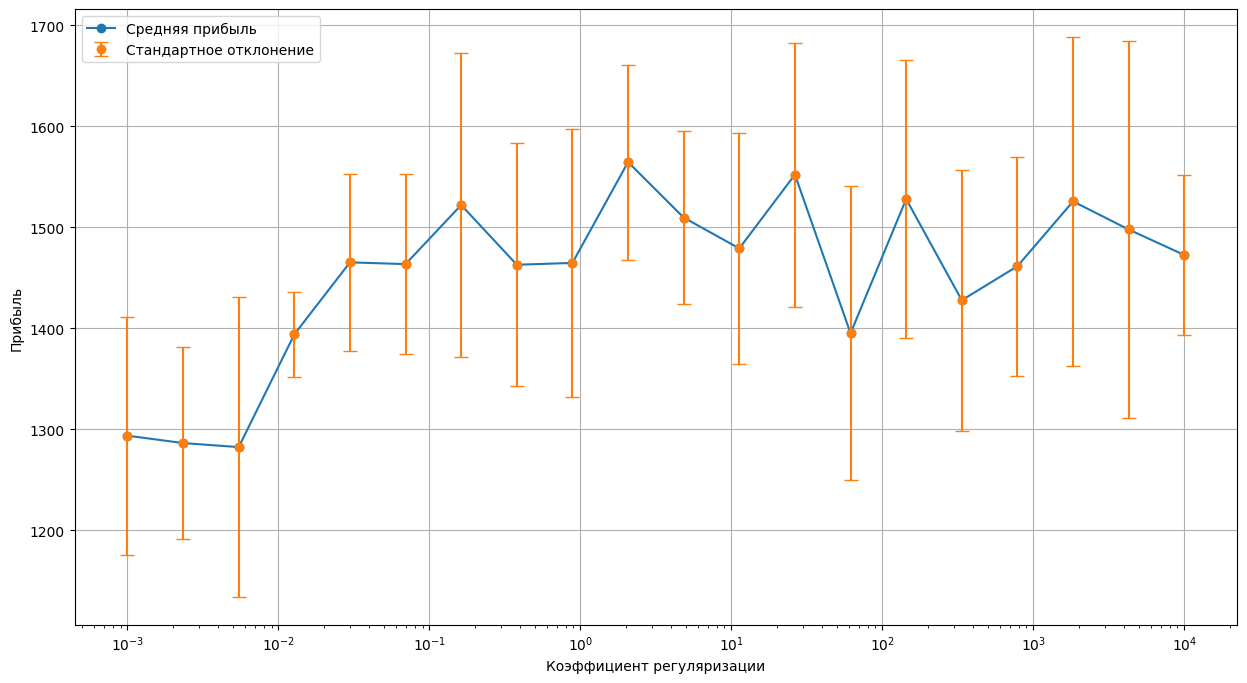

In [314]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(C_arr, profit_mean, marker='o', linestyle='-', label='Средняя прибыль')

ax.errorbar(C_arr, profit_mean, yerr=profit_std, fmt='o', capsize=5, label='Стандартное отклонение')
ax.set_xscale('log')
ax.set_xlabel('Коэффициент регуляризации')
ax.set_ylabel('Прибыль')
ax.grid()
ax.legend()
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [304]:
def profit_metric(y_true, y_pred):
    y_accept = y_true[y_pred == 1]
    cost = 2 * np.sum(y_pred == 1)
    revenue = np.sum(np.random.uniform(0, 20, size=np.sum(y_accept)))
    profit = revenue - cost
    return profit

profit_scorer = make_scorer(profit_metric, greater_is_better=True)

In [307]:
for i in range(5):
    param_grid = {'model__C': np.logspace(-3, 4, 20)}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid,
        scoring=profit_scorer,
        cv=cv
    )
    _ = grid_search.fit(X, y)
    print(f'Запуск {i}')
    print('Лучшая регуляризация:', grid_search.best_params_['model__C'])
    print('Лучшая прибыль:', grid_search.best_score_)

Запуск 0
Лучшая регуляризация: 4281.332398719387
Лучшая прибыль: 1557.6804315297454
Запуск 1
Лучшая регуляризация: 1832.9807108324337
Лучшая прибыль: 1539.6130413041496
Запуск 2
Лучшая регуляризация: 784.7599703514607
Лучшая прибыль: 1567.5467761401007
Запуск 3
Лучшая регуляризация: 0.029763514416313176
Лучшая прибыль: 1528.6675088939674
Запуск 4
Лучшая регуляризация: 4.832930238571752
Лучшая прибыль: 1561.6261504181252


Каждый раз находятся разные коэффициенты, но при этом лучшая прибыль примерно одинакова

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ recall показывает как много клиентов, готовых взять кредит мы обзванили. precision говорит о том, сколько мы совершили лишних звонков. Поэтому в некотором смысле recall максимизирует вырочку, а precision минимизирует расходы 



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
def cross_validate_threshold(
    X,
    y,
    n_splits=5,
    random_state=500,
    shuffle=True,
    threshold_arr = None
):
    profit_mean = np.zeros(len(threshold_arr))
    profit_std = np.zeros(len(threshold_arr))
    for i in range(len(threshold_arr)):
        threshold = threshold_arr[i]
        model = Pipeline([
            ('col_transform', column_transformer),
            ('model', LogisticRegression(random_state=42))
        ])

        metrics = []
        kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

        for train_index, test_index in kf.split(X):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            _ = model.fit(X_train, y_train)

            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_pred = (y_pred_proba >= threshold).astype(int)


            y_accept = y_test[y_pred == 1]
            cost = 2 * np.sum(y_pred == 1)
            revenue = np.sum(np.random.uniform(0, 20, size=np.sum(y_accept)))
            profit = revenue - cost

            metrics.append(profit)
        metrics = np.array(metrics)
        profit_mean[i] = metrics.mean()
        profit_std[i] = metrics.std()
        print(f'Обучение с threshold = {threshold} завершено')

    return profit_mean, profit_std

In [332]:
threshold_arr = np.arange(0, 1.01, 0.01)
profit_mean, profit_std = cross_validate_threshold(X, y, threshold_arr=threshold_arr)

Обучение с threshold = 0.0 завершено
Обучение с threshold = 0.01 завершено
Обучение с threshold = 0.02 завершено
Обучение с threshold = 0.03 завершено
Обучение с threshold = 0.04 завершено
Обучение с threshold = 0.05 завершено
Обучение с threshold = 0.06 завершено
Обучение с threshold = 0.07 завершено
Обучение с threshold = 0.08 завершено
Обучение с threshold = 0.09 завершено
Обучение с threshold = 0.1 завершено
Обучение с threshold = 0.11 завершено
Обучение с threshold = 0.12 завершено
Обучение с threshold = 0.13 завершено
Обучение с threshold = 0.14 завершено
Обучение с threshold = 0.15 завершено
Обучение с threshold = 0.16 завершено
Обучение с threshold = 0.17 завершено
Обучение с threshold = 0.18 завершено
Обучение с threshold = 0.19 завершено
Обучение с threshold = 0.2 завершено
Обучение с threshold = 0.21 завершено
Обучение с threshold = 0.22 завершено
Обучение с threshold = 0.23 завершено
Обучение с threshold = 0.24 завершено
Обучение с threshold = 0.25 завершено
Обучение с thre

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




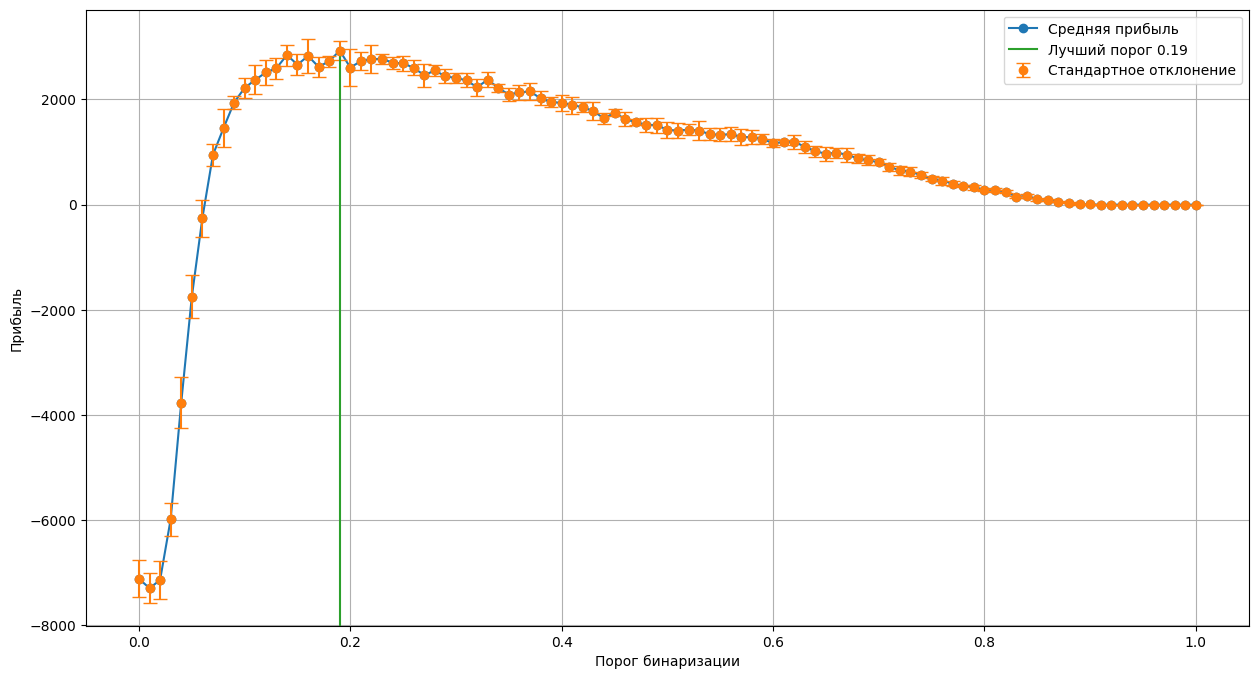

In [333]:
fig, ax = plt.subplots(figsize=(15, 8))

best_threshold = threshold_arr[np.argmax(profit_mean)]
best_profit = max(profit_mean)

ax.plot(threshold_arr, profit_mean, marker='o', linestyle='-', label='Средняя прибыль')

ax.errorbar(threshold_arr, profit_mean, yerr=profit_std, fmt='o', capsize=5, label='Стандартное отклонение')
ax.plot([best_threshold, best_threshold], [-8010, best_profit], label=f'Лучший порог {best_threshold:.2f}')
ax.set_ylim(bottom=-8010)
ax.set_xlabel('Порог бинаризации')
ax.set_ylabel('Прибыль')
ax.grid()
ax.legend()
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Как и ожидалось, для модели выгодно повышать recall, потому что матожидание прибыли, приносимой клиентом больше, чем потери от бесполезных звонков 

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [347]:
def cross_validate_threshold(
    X,
    y,
    n_splits=5,
    random_state=500,
    shuffle=True,
    threshold = None
):

    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        _ = model.fit(X_train, y_train)

        if threshold is None:
            y_pred = model.predict(X_test)
        else:
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_pred = (y_pred_proba >= threshold).astype(int)

        y_accept = y_test[y_pred == 1]
        cost = 2 * np.sum(y_pred == 1)
        revenue = np.sum(np.random.uniform(0, 20, size=np.sum(y_accept)))
        profit = revenue - cost

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        metric_dict = {
            'precison': precision,
            'recall': recall,
            'cost': cost,
            'revenue': revenue,
            'profit': profit
        }
        metrics.append(metric_dict)

    return pd.DataFrame(metrics)

In [348]:
model = Pipeline([
    ('col_transform', column_transformer),
    ('model', LogisticRegression(random_state=42))
])
metrics_data = cross_validate_threshold(X, y, threshold=best_threshold)
metrics_data

,precison,recall,cost,revenue,profit
0,0.428339,0.564378,2456,5359.746155,2903.746155
1,0.402844,0.555556,2532,4875.645497,2343.645497
2,0.437991,0.595518,2548,5553.808848,3005.808848
3,0.399242,0.597506,2640,5107.373358,2467.373358
4,0.431048,0.563337,2538,5426.324285,2888.324285


In [349]:
print(f'Средний recall: {metrics_data['recall'].mean()}')
print(f'std recall: {metrics_data['recall'].std()}')
print(f'Средний precision: {metrics_data['precison'].mean()}')
print(f'std precision: {metrics_data['precison'].std()}')

Средний recall: 0.5752586565010592
std recall: 0.019710999381516166
Средний precision: 0.41989268770936156
std precision: 0.017609778238198998


Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [343]:
def cross_validate_C(
    X,
    y,
    n_splits=5,
    random_state=500,
    shuffle=True,
    C_arr=None,
    threshold=None
):
    profit_mean = np.zeros(len(C_arr))
    for i in range(len(C_arr)):
        C = C_arr[i]
        model = Pipeline([
            ('col_transform', column_transformer),
            ('model', LogisticRegression(C=C, random_state=42))
        ])

        metrics = []
        kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

        for train_index, test_index in kf.split(X):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            _ = model.fit(X_train, y_train)

            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_pred = (y_pred_proba >= threshold).astype(int)

            y_accept = y_test[y_pred == 1]
            cost = 2 * np.sum(y_pred == 1)
            revenue = np.sum(np.random.uniform(0, 20, size=np.sum(y_accept)))
            profit = revenue - cost

            metrics.append(profit)
        metrics = np.array(metrics)
        profit_mean[i] = metrics.mean()
        print(f'Обучение с C = {C} завершено. Средняя прибыль: {profit_mean[i]}')
    C_best = C_arr[np.argmax(profit_mean)]
    max_profit = max(profit_mean)
    return C_best, max_profit

In [345]:
C_arr = np.logspace(-3, 4, 20)
C_best, max_profit = cross_validate_C(X, y, C_arr=C_arr, threshold=best_threshold)

Обучение с C = 0.001 завершено. Средняя прибыль: 2639.063644337749
Обучение с C = 0.002335721469090121 завершено. Средняя прибыль: 2774.870758136393
Обучение с C = 0.00545559478116852 завершено. Средняя прибыль: 2906.4022881929495
Обучение с C = 0.012742749857031334 завершено. Средняя прибыль: 2845.351530499537
Обучение с C = 0.029763514416313176 завершено. Средняя прибыль: 2785.544304078733
Обучение с C = 0.06951927961775606 завершено. Средняя прибыль: 2733.464135395522
Обучение с C = 0.1623776739188721 завершено. Средняя прибыль: 2763.7120405028018
Обучение с C = 0.37926901907322497 завершено. Средняя прибыль: 2737.7819662425054
Обучение с C = 0.8858667904100823 завершено. Средняя прибыль: 2806.8978883818436
Обучение с C = 2.069138081114788 завершено. Средняя прибыль: 2785.496881003818
Обучение с C = 4.832930238571752 завершено. Средняя прибыль: 2812.3295586959207
Обучение с C = 11.288378916846883 завершено. Средняя прибыль: 2830.6869188251626
Обучение с C = 26.366508987303554 заверш

In [351]:
best_model = Pipeline([
    ('col_transform', column_transformer),
    ('model', LogisticRegression(C=C_best, random_state=42))
])
metrics_data_best = cross_validate_threshold(X, y, threshold=best_threshold)
metrics_data_best

,precison,recall,cost,revenue,profit
0,0.428339,0.564378,2456,5194.312750,2738.312750
1,0.402844,0.555556,2532,4942.015354,2410.015354
2,0.437991,0.595518,2548,5503.764705,2955.764705
3,0.399242,0.597506,2640,5500.380792,2860.380792
4,0.431048,0.563337,2538,5485.538574,2947.538574


In [352]:
model = Pipeline([
    ('col_transform', column_transformer),
    ('model', LogisticRegression(random_state=42))
])
metrics_data = cross_validate_threshold(X, y)
metrics_data

,precison,recall,cost,revenue,profit
0,0.725490,0.238197,612,2250.405017,1638.405017
1,0.643077,0.227669,650,2052.923463,1402.923463
2,0.636364,0.224120,660,2096.794908,1436.794908
3,0.685015,0.253968,654,2279.671038,1625.671038
4,0.616099,0.204943,646,2112.747623,1466.747623


Парный t-критерий

In [354]:
from scipy.stats import ttest_rel

best_profit = metrics_data_best['profit'].to_numpy()
profit = metrics_data['profit'].to_numpy()

t_statistic, p_value = ttest_rel(best_profit, profit)

print(f"t-статистика: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Разница между моделями статистически значима")
else:
    print("Разница между моделями не статистически значима")

t-статистика: 12.5059
p-value: 0.0002
Разница между моделями статистически значима
